In [81]:
#导入Pandas
import pandas as pd
#导入金融数据获取模块datareader
import pandas_datareader.data as web
#导入numpy
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [82]:
#首先我们来定义一个函数，用来获取数据
#传入的三个参数分别是开始日期，结束日期和输出的文件名
def load_stock(start_date, end_date, output_file):
    #首先让程序尝试读取已下载并保存的文件
    try:
        df = pd.read_pickle(output_file)
        #如果文件已存在，则打印载入股票数据文件完毕
        print('载入股票数据文件完毕')
    #如果没有找到文件，则重新进行下载
    except FileNotFoundError:
        print('文件未找到，重新下载中')
        #这里制定下载中国平安（601318）的交易数据
        #下载源为yahoo
        df =yf.download('0056.TW', start_date, end_date)
        #下载成功后保存为pickle文件
        df.to_pickle(output_file)
        #并通知我们下载完成
        print('下载完成')
    #最后将下载的数据表进行返回
    return df

In [83]:
#下面使用我们定义好的函数来获取中国平安的交易数据
#获取三年的数据，从2017年3月9日至2020年的3月5日
#保存为名为601318的pickle文件
zgpa = load_stock(start_date = '2021-08-19', 
                  end_date = '2024-08-19',
                 output_file = '0056.pkl')

载入股票数据文件完毕


In [84]:
#可以检查一下数据的前五行
zgpa.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-08-19,32.880001,32.880001,32.290001,32.320000,24.656717,44646608
2021-08-20,32.400002,32.490002,32.000000,32.259998,24.610941,24869457
2021-08-23,32.520000,32.900002,32.520000,32.880001,25.083935,16402007
2021-08-24,33.009998,33.080002,32.660000,32.799999,25.022905,20358402
2021-08-25,32.950001,33.000000,32.799999,33.000000,25.175486,10040196


In [85]:
def classification_tc(df):
    df['Open-Close'] = df['Open'] - df['Close']
    df['High-Low'] = df['High'] - df['Low']
    # 确保目标变量是离散的类别标签 1 或 -1
    df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    y = df['target']
    return df, X, y

In [86]:
#下面定义一个用于回归的函数
#特征的添加和分类函数类似
#只不过target字段改为次日收盘价减去当日收盘价
def regression_tc(df):
    df['Open-Close'] = df['Open'] - df['Close']
    df['High-Low'] = df['High'] - df['Low']
    df['target'] = df['Close'].shift(-1) - df['Close']
    df = df.dropna()
    X = df[['Open-Close', 'High-Low']]
    y = df['target']
    #将处理好的数据表以及X与y进行返回
    return(df,X,y)

In [87]:
#导入数据集拆分工具train_test_split
from sklearn.model_selection import train_test_split
#使用train_test_split定义一个拆分数据集的函数，默认训练集占比80%
def split_data(X, y, train_size=0.8):
    #将拆分结果进行返回
    return train_test_split(X, y, shuffle=False, train_size=train_size)

In [88]:
#使用classification_tc函数生成数据集的特征与目标
df, X, y = classification_tc(zgpa)
#将数据集拆分为训练集与验证集
X_train, X_test, y_train, y_test =\
train_test_split(X, y, shuffle=False,train_size=0.8)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Open-Close,High-Low,target
Date,,,,,,,,,
2021-08-19,32.880001,32.880001,32.290001,32.320000,24.656717,44646608,0.560001,0.590000,-1
2021-08-20,32.400002,32.490002,32.000000,32.259998,24.610941,24869457,0.140003,0.490002,1
2021-08-23,32.520000,32.900002,32.520000,32.880001,25.083935,16402007,-0.360001,0.380001,-1
2021-08-24,33.009998,33.080002,32.660000,32.799999,25.022905,20358402,0.209999,0.420002,1
2021-08-25,32.950001,33.000000,32.799999,33.000000,25.175486,10040196,-0.049999,0.200001,-1


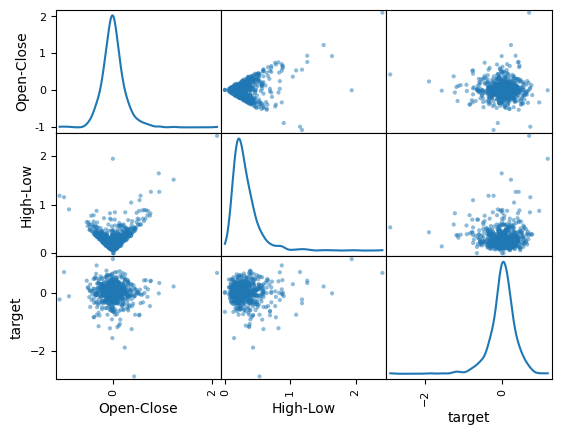

In [89]:
#可以简单地对我们添加的特征进行可视化
#首先是用刚才定义好的函数来处理一下原始数据
df, X, y = regression_tc(zgpa)
#使用散点图矩阵来进行可视化
pd.plotting.scatter_matrix(zgpa[['Open-Close','High-Low','target']], 
                           diagonal='kde')
#显示图像
plt.show()

In [90]:
#将数据集拆分为训练集和验证集，训练集占比80%
X_train, X_test, y_train, y_test = split_data(X, y, train_size=0.8)

In [91]:
#导入线性回归模型
from sklearn.linear_model import LinearRegression
#创建一个线性回归实例
reg = LinearRegression()
#并拟合训练集
reg.fit(X_train, y_train)

LinearRegression()

In [92]:
#导入模型评分工具R2和MSE
from sklearn.metrics import r2_score, mean_squared_error
#将模型在训练集和验证集的得分进行打印
print('训练集中的R2分数:%.2f'%r2_score(y_train, reg.predict(X_train)))
print('验证集中的R2分数:%.2f'%r2_score(y_test, reg.predict(X_test)))
print('训练集的MSE:%.2f'%mean_squared_error(y_train, reg.predict(X_train)))
print('验证集的MSE:%.2f'%mean_squared_error(y_test, reg.predict(X_test)))

训练集中的R2分数:0.00
验证集中的R2分数:-0.01
训练集的MSE:0.09
验证集的MSE:0.20


In [93]:
#下面我们来对策略进行评估
#先保证数据集中没有空值
zgpa = zgpa.dropna()
# 使用线性回归模型预测次日股票的涨跌幅
zgpa['Predict_Signal'] = pd.Series(reg.predict(X), index=X.index)

# 在数据集中添加一个字段，用当日收盘价除以前一日收盘价，并取其自然对数
zgpa['zgpa_Return'] = np.log(zgpa['Close']/zgpa['Close'].shift(1))

# 定义一个计算回报的函数
def calculate_return(df, split_value, symbol):
    # 该股票基准收益为‘zgpa_Return’的总和*1000
    cum_zgpa_return = df[split_value:]['%s_Return' % symbol].cumsum()*1000
    # 将计算结果进行返回
    return cum_zgpa_return

# 再定义一个计算使用策略交易的收益
def strategy_return(df, split_value, symbol):
    # 使用策略交易的收益为模型‘zgpa_Return’乘以模型预测的涨跌幅
    df['Strategy_Return'] = df['%s_Return' % symbol] * df['Predict_Signal'].shift(1)
    # 将每日策略交易的收益加和并乘以1000
    cum_strategy_return = df[split_value:]['Strategy_Return'].cumsum()*1000
    # 将计算结果进行返回
    return cum_strategy_return

# 使用定义好的函数来计算基准收益
cum_zgpa_return = calculate_return(zgpa, split_value=len(X_train), symbol='zgpa')

# 查看一下计算结果
cum_zgpa_return

Date
2024-01-09    -2.189927
2024-01-10    -9.064696
2024-01-11    -4.934229
2024-01-12    -6.584327
2024-01-15    -6.584327
                ...    
2024-08-09    21.104647
2024-08-12    35.195073
2024-08-13    37.831470
2024-08-14    47.787042
2024-08-15    42.821595
Name: zgpa_Return, Length: 146, dtype: float64

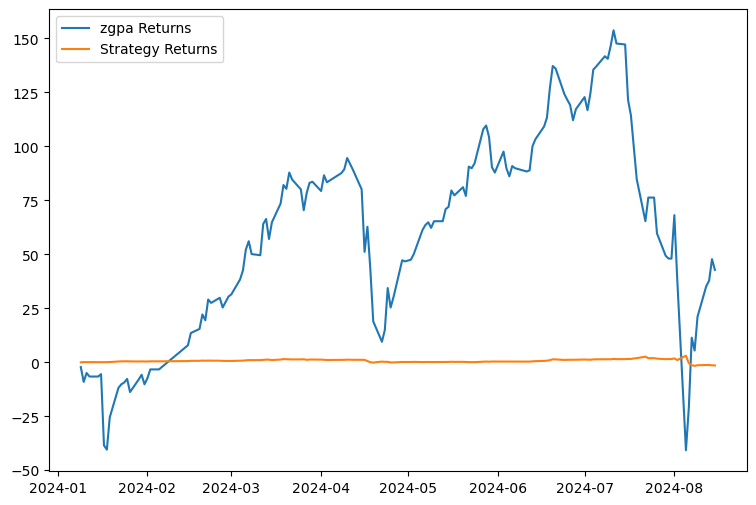

In [94]:
#使用定义好的函数计算算法交易的收益
cum_strategy_return = strategy_return(zgpa,split_value=len(X_train), symbol='zgpa')
#定义一个绘图函数，用来对比基准收益和算法交易的收益
def plot_chart(cum_symbol_return, cum_strategy_return, symbol):
    #首先是定义画布的尺寸
    plt.figure(figsize=(9,6))
    #使用折线图绘制基准收益
    plt.plot(cum_symbol_return, label='%s Returns'%symbol)
    #使用折线图绘制算法交易收益
    plt.plot(cum_strategy_return, label = 'Strategy Returns')
    #添加图注
    plt.legend()
    #显示图像
    plt.show()
#使用该函数绘制中国平安的收益对比图
plot_chart(cum_zgpa_return, cum_strategy_return, symbol='zgpa')

In [95]:
#定义一个计算夏普指数的函数
def sharpe_ratio(symbol_return, strategy_return):
    #使用.std()计算出算法交易收益的标准差
    strategy_std = strategy_return.std()
    #夏普指数为（算法交易收益-基准收益）/算法交易收益的标准差
    sharpe = (strategy_return - symbol_return)/strategy_std
    #返回计算结果的均值
    return sharpe.mean()
#打印模型交易的夏普指数
print(sharpe_ratio(cum_zgpa_return, cum_strategy_return))

-80.1266975041843


In [96]:
#导入套索回归和岭回归
from sklearn.linear_model import Lasso, Ridge

In [97]:
#创建一个alpha为10的套索回归实例
lasso = Lasso(alpha = 10)
#拟合训练集
lasso.fit(X_train, y_train)
#查看模型在验证集的R2分数
lasso.score(X_test, y_test)

-0.00038878241940509817

In [98]:
#创建一个alpha参数为100000的岭回归实例
#并拟合训练集
ridge = Ridge(alpha=100000).fit(X_train, y_train)
#查看模型在验证集的R2分数
ridge.score(X_test, y_test)

-0.0003905439027807045

In [99]:
#导入决策树回归模型
from sklearn.tree import DecisionTreeRegressor

In [100]:
#创建一个决策树回归实例
#并拟合训练集
dt = DecisionTreeRegressor().fit(X_train, y_train)
#查看模型在验证集中的分数
dt.score(X_test, y_test)

-0.6701118285108969

===使用分类算法===

In [101]:
#使用classification_tc函数生成数据集的特征与目标
df, X, y = classification_tc(zgpa)
#将数据集拆分为训练集与验证集
X_train, X_test, y_train, y_test =\
split_data(X, y, train_size=0.8)

In [102]:
#导入KNN
from sklearn.neighbors import KNeighborsClassifier

In [103]:
#创建一个knn实例，n_neighbors取10
knn = KNeighborsClassifier(n_neighbors=10)
#使用knn拟合训练集
knn.fit(X_train, y_train)
#打印模型在训练集中的准确率
print(knn.score(X_train, y_train))
#打印模型在验证集中的准确率
print(knn.score(X_test, y_test))

0.6134020618556701
0.4931506849315068


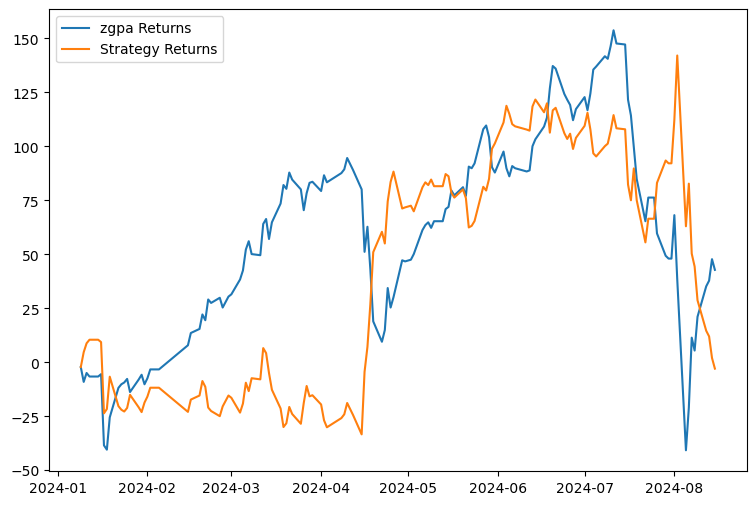

In [104]:
#首先还是确保数据中没有空值
zgpa=zgpa.dropna()
#使用knn进行预测，并写入到‘Predict_Signal’字段
zgpa['Predict_Signal'] = knn.predict(X)
#计算基准收益
cum_zgpa_return = calculate_return(zgpa, split_value=len(X_train), symbol='zgpa')
#计算算法交易的收益
cum_strategy_return = strategy_return(zgpa, 
                                                split_value=len(X_train),
                                     symbol='zgpa')
#使用图形进行对比
plot_chart(cum_zgpa_return, cum_strategy_return, symbol='zgpa')

In [105]:
#导入支持向量机分类器SVC
from sklearn.svm import SVC

In [106]:
#创建SVC实例
svc = SVC(gamma='auto')
#拟合训练集
svc.fit(X_train, y_train)
#打印模型在训练集中的准确率
print(svc.score(X_train, y_train))
#打印模型在验证集中的准确率
print(svc.score(X_test, y_test))

0.5395189003436426
0.547945205479452


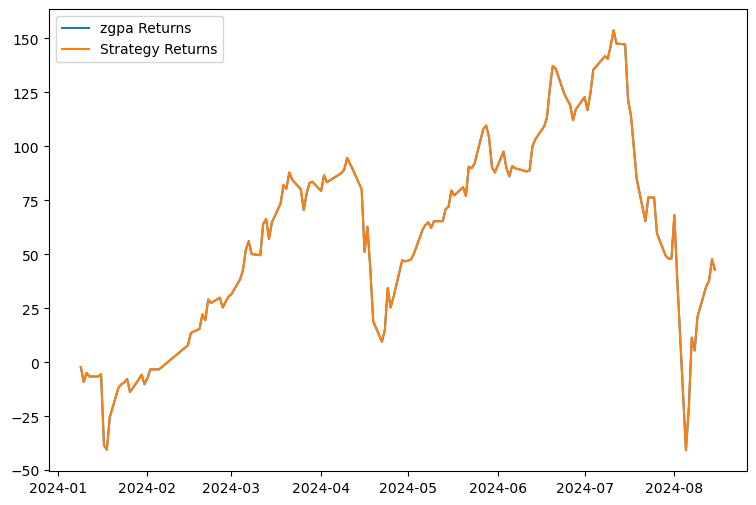

In [107]:
#同样使用图像来对比模型收益和基准收益
zgpa['Predict_Signal'] = svc.predict(X)
cum_zgpa_return = calculate_return(zgpa, split_value=len(X_train), symbol='zgpa')
cum_strategy_return = strategy_return(zgpa, 
                                                split_value=len(X_train),
                                     symbol='zgpa')
plot_chart(cum_zgpa_return, cum_strategy_return, symbol='zgpa')

In [108]:
#导入逻辑回归
from sklearn.linear_model import LogisticRegression

In [109]:
#创建逻辑回归实例
lr = LogisticRegression(solver='lbfgs')
#拟合训练集
lr.fit(X_train, y_train)
#分别打印模型在训练集与验证集中的准确率
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.5378006872852233
0.5547945205479452


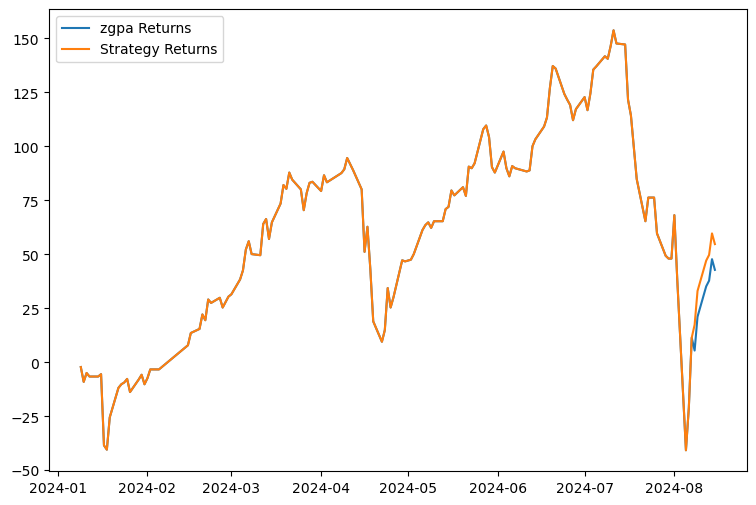

In [110]:
#使用图像对比逻辑回归模型的收益和基准收益
zgpa['Predict_Signal'] = lr.predict(X)
cum_zgpa_return = calculate_return(zgpa, split_value=len(X_train), symbol='zgpa')
cum_strategy_return = strategy_return(zgpa, 
                                                split_value=len(X_train),
                                     symbol='zgpa')
plot_chart(cum_zgpa_return, cum_strategy_return, symbol='zgpa')